In [2]:
import os
import pathlib
 
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3071, done.
remote: Counting objects: 100% (3071/3071), done.
remote: Compressing objects: 100% (2596/2596), done.
remote: Total 3071 (delta 763), reused 1351 (delta 433), pack-reused 0
Receiving objects: 100% (3071/3071), 33.30 MiB | 29.12 MiB/s, done.
Resolving deltas: 100% (763/763), done.


In [3]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pathlib

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install tensorflow-object-detection-api

     |████████████████████████████████| 577 kB 30.5 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 3.5 MB 66.0 MB/s 
  Created wheel for tensorflow-object-detection-api: filename=tensorflow_object_detection_api-0.1.1-py3-none-any.whl size=844512 sha256=99bc180d4e5eefa5052d67297153eb5d7dc0a5a2f7e015d2c59db7306a12c2d7
  Stored in directory: /root/.cache/pip/wheels/71/7e/a2/461ab817fbaef68ec9cc60df16d3669d1285f032e4c98179bf
Successfully built tensorflow-object-detection-api


In [6]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [7]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [8]:
#Loader Function
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [9]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS ='/content/models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [10]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/content/models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS 

[PosixPath('/content/models/research/object_detection/test_images/image1.jpg'),
 PosixPath('/content/models/research/object_detection/test_images/image2.jpg'),
 PosixPath('/content/models/research/object_detection/test_images/image3.jpg')]

In [11]:
def read_label_map(label_map_path):

    item_id = None
    item_name = None
    items = {}
    
    with open(label_map_path, "r") as file:
        for line in file:
            line.replace(" ", "")
            if line == "name{":
                pass
            elif line == "}":
                pass
            elif "id" in line:
                item_id = int(line.split(":", 1)[1].strip())
            elif "display_name" in line:
                item_name = line.split(":", 1)[1].replace("'", "").strip()

            if item_id is not None and item_name is not None:
                items[item_id] = item_name
                item_id = None
                item_name = None

    return items


In [12]:
ITEAM = read_label_map(PATH_TO_LABELS)
ITEAM[38]

'"kite"'

In [13]:
model_name = 'faster_rcnn_inception_v2_coco_2018_01_28'
detection_model = load_model(model_name)


149135360/149119618 [==============================] - 1s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [14]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [15]:
detection_model.output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [16]:
detection_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

In [17]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [18]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=6)

  display(Image.fromarray(image_np))
  return output_dict

In [19]:
!pip install gTTs

In [20]:
from gtts import gTTS 
from IPython.display import Audio 

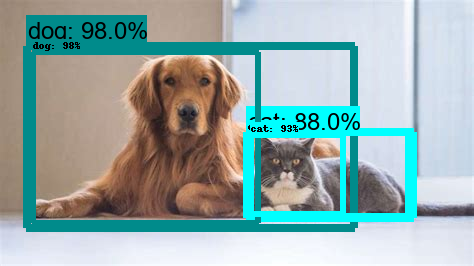

['"cat"', '"dog"']


In [21]:
#for image_path in TEST_IMAGE_PATHS:
import numpy as np
import time
xx=show_inference(detection_model, '/content/drive/MyDrive/images/hk.png')
#ITEAM[xx['detection_classes'][0]]
#print(xx['detection_scores'])
ind=0
pred = np.zeros((0))
for i in xx['detection_scores']:
  if i>0.50:
    pred = np.append(pred,xx['detection_classes'][ind])
  ind = ind+1
pred = np.unique(pred)
s = []
for i in range(len(pred)):
  #print(ITEAM[int(pred[i])])
  s.append(ITEAM[int(pred[i])])
print(s)

In [22]:
A = "There are "
if(len(s)==1):
  A="There is "
for i in range(0,len(s)):
  A = A+s[i]
  A = A+" AND "
A=A+" Maybe something else."
print(A)

There are "cat" AND "dog" AND  Maybe something else.


In [23]:
tts = gTTS(A) 
tts.save('1.wav') 
sound_file = '1.wav'
Audio(sound_file, autoplay=True)